# Ejercicio 4 extensión de codo

Para este caso se hace uso de los angulos del codo para utilizar como caracteristica adicional en el modelo

In [ ]:
def extract_video_features(frames):
    features = {}

    # Ángulos del codo
    elbow_angles = []
    for frame in frames:

        left_arm = frame['pose']['left_arm']
        left_angle = calculate_angle(
            left_arm[0],
            left_arm[1],
            left_arm[2]
        )
        elbow_angles.append(left_angle)


        right_arm = frame['pose']['right_arm']
        right_angle = calculate_angle(
            right_arm[0],
            right_arm[1],
            right_arm[2]
        )
        elbow_angles.append(right_angle)


    features['max_elbow_angle'] = np.max(elbow_angles)
    features['min_elbow_angle'] = np.min(elbow_angles)
    features['mean_elbow_angle'] = np.mean(elbow_angles)



    return features

In [ ]:
import numpy as np


def calculate_angle(a, b, c):

    a = np.array(a[:2])
    b = np.array(b[:2])
    c = np.array(c[:2])

    ba = a - b
    bc = c - b


    dot_product = np.dot(ba, bc)
    mag_ba = np.linalg.norm(ba)
    mag_bc = np.linalg.norm(bc)


    cosine_angle = dot_product / (mag_ba * mag_bc + 1e-10)
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1, 1)))

    return angle

def calculate_shoulder_angle(hip, shoulder, wrist):
    return calculate_angle(hip, shoulder, wrist)


def extract_video_features(frames):
    features = {}


    elbow_angles = []
    for frame in frames:

        left_arm = frame['pose']['left_arm']
        left_angle = calculate_angle(left_arm[0], left_arm[1], left_arm[2])
        elbow_angles.append(left_angle)

        right_arm = frame['pose']['right_arm']
        right_angle = calculate_angle(right_arm[0], right_arm[1], right_arm[2])
        elbow_angles.append(right_angle)

    features['max_elbow_angle'] = np.max(elbow_angles)
    features['min_elbow_angle'] = np.min(elbow_angles)
    features['mean_elbow_angle'] = np.mean(elbow_angles)

    shoulder_angles = []
    for frame in frames:

        hip = [0.5, 0.9]
        shoulder = frame['pose']['left_arm'][0][:2]
        wrist = frame['pose']['left_arm'][2][:2]
        angle = calculate_shoulder_angle(hip, shoulder, wrist)
        shoulder_angles.append(angle)

    features['shoulder_rom'] = np.max(shoulder_angles) - np.min(shoulder_angles)



    return features

## Se extraen las etiquetas a un dataframe para el modelado

In [ ]:
  import pandas as pd


with open('/content/drive/MyDrive/pract3Landmrks/labelsejer4.json', 'r') as f:
    data = json.load(f)


X = []
y = []
for video_name, frames in data.items():
    features = extract_video_features(frames)
    X.append(features)
    y.append(frames[0]['label'])  #

df = pd.DataFrame(X)
df['label'] = y

## Entrenamiento utilizando RandomFores GBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)


models = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': GradientBoostingClassifier()
}


param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        full       1.00      0.50      0.67         2
        none       0.50      1.00      0.67         2
     partial       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.44         6
weighted avg       0.50      0.50      0.44         6



#Modelado SVM

In [1]:
import json
import numpy as np
import os

def load_landmark_data(file_path):

    if not os.path.isfile(file_path):
        raise ValueError(f"La ruta {file_path} no es un archivo válido.")


    with open(file_path, "r") as f:
        data = json.load(f)

    X, y = [], []

    max_landmarks = 0

    for video_name, frames in data.items():
        for frame_data in frames:
            landmarks = []


            pose = frame_data.get("pose", {})
            hands = frame_data.get("hands", [])


            for key in ["left_arm", "right_arm"]:
                if key in pose:
                    for coords in pose[key]:
                        landmarks.extend(coords)


            for hand_points in hands:
                for coords in hand_points:
                    landmarks.extend(coords)


            max_landmarks = max(max_landmarks, len(landmarks))


            X.append(landmarks)
            y.append(frame_data["label"])


    for i in range(len(X)):
        while len(X[i]) < max_landmarks:
            X[i].append(0.0)

    return np.array(X), np.array(y)


file_path = "/content/drive/MyDrive/pract3Landmrks/labelsejer4.json"


X, y = load_landmark_data(file_path)
X = X / np.max(X)

print(f"Datos cargados: {X.shape}, Etiquetas: {len(y)}")

Datos cargados: (8238, 207), Etiquetas: 8238


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de entrenamiento:", X_train.shape, "Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (6590, 207) Tamaño de prueba: (1648, 207)


In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


model = SVC(kernel="linear")
model.fit(X_train, y_train_encoded)

SVC(kernel='linear')

In [4]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")


print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Precisión del modelo: 0.6135
              precision    recall  f1-score   support

        full       0.87      0.44      0.59       620
        none       0.50      0.94      0.65       431
     partial       0.65      0.55      0.60       597

    accuracy                           0.61      1648
   macro avg       0.67      0.65      0.61      1648
weighted avg       0.69      0.61      0.61      1648



Se obtuvo bajo resultado

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prueba modelo MLPClassifier datos escalados

In [6]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
model_mlp.fit(X_train_scaled, y_train_encoded)

y_pred_mlp = model_mlp.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        full       0.99      0.98      0.98       620
        none       0.98      1.00      0.99       431
     partial       0.98      0.98      0.98       597

    accuracy                           0.98      1648
   macro avg       0.98      0.98      0.98      1648
weighted avg       0.98      0.98      0.98      1648



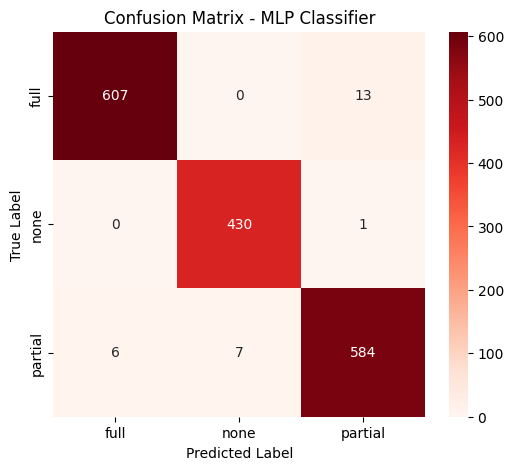

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_mlp)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MLP Classifier")
plt.show()

## Evaluación externa con video nuevo
Se clasifica el movimiento correctamente

In [14]:
import cv2
import mediapipe as mp
import numpy as np
import json

mp_holistic = mp.solutions.holistic

def extract_landmarks_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    holistic = mp_holistic.Holistic(static_image_mode=False)

    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        landmarks = []


        if results.pose_landmarks:
            pose_landmarks = results.pose_landmarks.landmark
            left_arm_indices = [11, 13, 15]
            right_arm_indices = [12, 14, 16]

            for index in left_arm_indices + right_arm_indices:
                landmarks.extend([pose_landmarks[index].x, pose_landmarks[index].y, pose_landmarks[index].z])


        if results.left_hand_landmarks:
            landmarks.extend([lm.x for lm in results.left_hand_landmarks.landmark])
            landmarks.extend([lm.y for lm in results.left_hand_landmarks.landmark])
            landmarks.extend([lm.z for lm in results.left_hand_landmarks.landmark])

        if results.right_hand_landmarks:
            landmarks.extend([lm.x for lm in results.right_hand_landmarks.landmark])
            landmarks.extend([lm.y for lm in results.right_hand_landmarks.landmark])
            landmarks.extend([lm.z for lm in results.right_hand_landmarks.landmark])

        landmarks_list.append(landmarks)

    cap.release()
    holistic.close()


    max_landmarks = 207
    for i in range(len(landmarks_list)):
        while len(landmarks_list[i]) < max_landmarks:
            landmarks_list[i].append(0.0)

    return np.array(landmarks_list)

video_path = "/content/drive/MyDrive/pract3vids/test2.mp4"
X_new = extract_landmarks_from_video(video_path)

In [15]:
from sklearn.preprocessing import StandardScaler

X_new_scaled = scaler.transform(X_new)

### Se predice correctamente con video de evaluación externa

In [16]:

y_pred_new = model_mlp.predict(X_new_scaled)


from collections import Counter
most_common_label = Counter(y_pred_new).most_common(1)[0][0]

predicted_class = label_encoder.inverse_transform([most_common_label])[0]

print(f"El modelo predice que el ejercicio realizado en el video es: {predicted_class}")

El modelo predice que el ejercicio realizado en el video es: full


## Evaluación externa
Obtuvimos un buen resultado en el entrenamiento usando MLP classifier

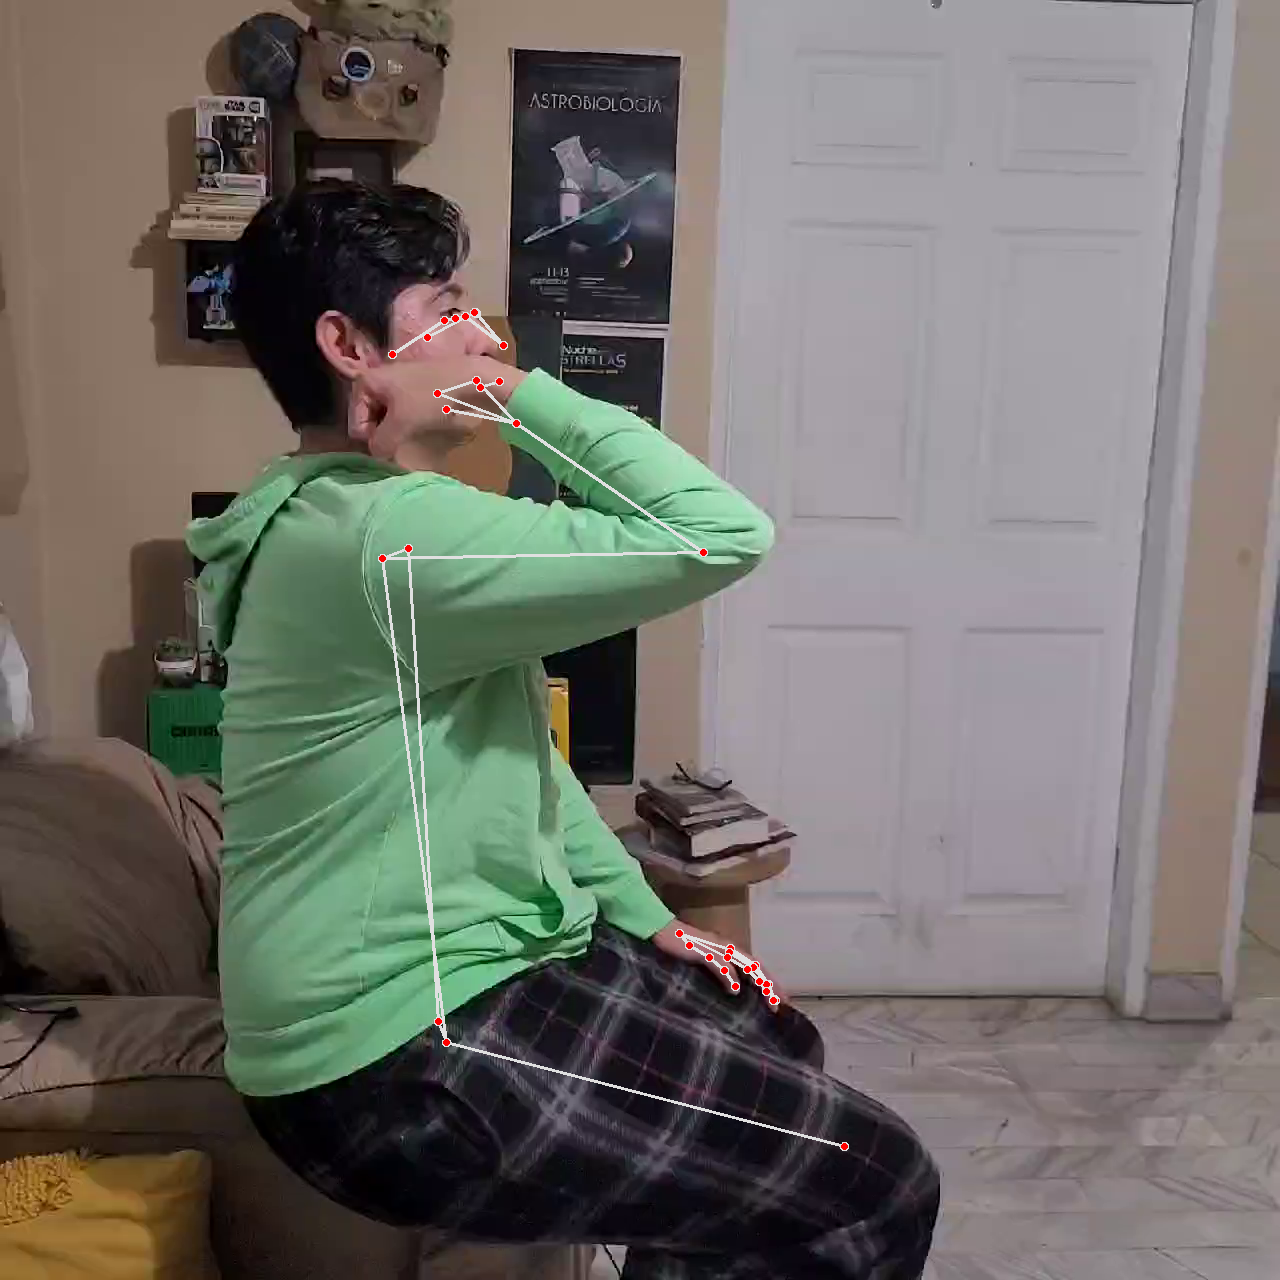

In [17]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

video_path = "/content/drive/MyDrive/pract3vids/test2.mp4"
cap = cv2.VideoCapture(video_path)

with mp_holistic.Holistic(static_image_mode=False) as holistic:
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)


        mp_drawing.draw_landmarks(
            frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


        cv2_imshow(frame)


cap.release()